# ________________Musk Notifier__________________

*I chose to work on this project since it involves aspects such as web scraping, data collection, cleaning, augmentation, training, and deployment.*

## Introduction and problem statement
Wiki: *"Elon Reeve Musk FRS (/ˈiːlɒn/; born June 28, 1971) is an engineer, industrial designer, and technology entrepreneur. In December 2016, he was ranked 21st on the Forbes list of The World's Most Powerful People, and was ranked joint-first on the Forbes list of the Most Innovative Leaders of 2019."*

Videos of Elon Musk are quite popular on YouTube, with a lot of people watching from various walks of life. Painting the picture of a genius entreprenuer, he imbibes the role of a celebrity figure. His videos are often watched for inspiration, as food for thought and sometimes only for his supposed eccentricity. This has led to Elon having a lot of followers, including Youtubers that hold discussions about him on their own channels. Due to this and his name being used abundantly in plenty of content online, one might find it hard to filter and catch hold of new videos that actually have him in it as opposed to having some other Youtubers discussing him. All we try to do is make his videos prompt and more accessible.

## Solution proposal
The aim is to seach YouTube daily for videos with Elon in them and save the links to those videos in a file. Those videos are to be checked that appear in results when searched for 'Elon Musk'. The results are filtered to show only those videos which have been published in the last 24 hours (Since the script is meant once every day).

A face detection package is used and in order to recognise the face as Elon's, a machine learning model is made use of. The model is trained using faces of Elon. Still images from the videos to be checked for Elon are captured. The faces are isolated and a prediction is made using the trained model. If the number Elon Musk faces in the (multiple) images of a video are predicted to be more than a predefined threshold, then that video is flagged to have Elon in it. Finally the list of links are saved in a file on the desktop.

### Other possible solutions
(.) The face detection package used can also recognise faces, but instead I chose to build a machine learning model myself.
(.) Instead of only taking the still images from the videos, the whole video could be made use of for classification into categories: With Elon and Without Elon. But that seems to be bandwidth heavy and alon harder (read longer) to train. I think the solution can be less hungry for data.
(.) Audio could be made use of in training instead. But again the entire audio length will have to be made use of.
(.) One might think that the title of the video or it's description or channel name can be used to tell if the video contains Elon. But since videos with Elon are released by multiple sources, the channels can't be kept track of. Some of the videos do not even have a description, hence using the video metadata for classification might not turn out to be such a great idea.

## Methodology
### Elon Musk videos are searched for on YouTube
 Selenium is used to go to each video link. The links are to be manually collected initially, for training purposes. Selenium then takes screenshots in regular intervals. It achieves this by seeking through the video. Once a particular video is done, it moves on to the next video and repeats until all videos have had their still images collected. 
### Faces are extracted and used for training
 As soon as there is a screenshot taken, all the faces in the image are extracted using the 'face_recognition' package and saved in the 'save_path' location provided. The faces are then manually sorted into two classes. One that is Elon's face and another which is not Elon's face. These images are then used to train a CNN model. The trained model is then saved and used to classify new videos.
### New videos are checked for Elon
 'Elon Musk' is searched for on YouTube. The results are filtered to show only videos from the past 24 hours and then the first 10 videos videos have their still images taken at regular intervals. If a video has more than a predefined percentage of images that test positive for Elon, then that link is flagged and appended to be saved in a file after all the other videos have been checked.

In [4]:
# Takes YouTube links or a search term as parameter and saves list of videos with Elon. 
# Either 'links' or 'search_term' must be provided for it to work. If 'delete_images' is
# set to true then the images are deleted after analysis.
def get_faces(links = None, save_path = None, search_term = None, delete_images = False): 
    
    #Selenium to save the still images of each video.
    from selenium.webdriver.common.by import By
    from selenium.webdriver.support.ui import WebDriverWait
    from selenium.webdriver.support import expected_conditions as EC
    from selenium import webdriver
    from selenium.webdriver.chrome.options import Options
    from selenium.webdriver import ActionChains
    
    #To load the trained model for prediction and for image preprocessing.
    from tensorflow.keras.preprocessing import image as tf_image
    from tensorflow.keras.models import load_model
    
    #For recognising faces, saving and navigating directories.
    import matplotlib.pyplot as plt
    import face_recognition
    import os
    import shutil
    import time
    import csv
    import numpy as np
    
    image_classifier = load_model(r"C:\Users\Anurag\Desktop\super_model")
    
    # Initialising filename for each face image, full image(debugging purposes)
    # and the list to append links with elon.
    image_save_number = 1
    main_image_save_number = 1   
    links_with_elon = [] 
    
    #Takes the first ten links in the results page for the given 'search_term'.   
    if search_term:
        
        options = Options()
        path_to_extension = r"C:\Users\Anurag\1First\Projects\EM files\3.7_0"
        #options.add_argument("--headless")
        options.add_argument("load-extension=" + path_to_extension)
        options.add_argument("start-maximized")
        options.add_argument("disable-infobars")
        options.add_argument("--mute-audio")
        driver=webdriver.Chrome(options=options, executable_path=r"C:\Users\Anurag\Downloads\chromedriver_win32\chromedriver.exe")
        
        driver.get("https://www.youtube.com/")
        time.sleep(3)
        WebDriverWait(driver, 15).until(EC.element_to_be_clickable((By.CSS_SELECTOR, "input#search"))).send_keys(search_term)
        driver.find_element_by_css_selector("button.style-scope.ytd-searchbox#search-icon-legacy").click()
        time.sleep(3)
        #Filter results to show only the videos uploaded in the last 24 hours.
        driver.find_element_by_xpath("/html/body/ytd-app/div/ytd-page-manager/ytd-search/div[1]/ytd-two-column-search-results-renderer/div/ytd-section-list-renderer/div[1]/div[2]/ytd-search-sub-menu-renderer/div[1]/div/ytd-toggle-button-renderer/a/paper-button").click()
        driver.find_element_by_xpath("/html/body/ytd-app/div/ytd-page-manager/ytd-search/div[1]/ytd-two-column-search-results-renderer/div/ytd-section-list-renderer/div[1]/div[2]/ytd-search-sub-menu-renderer/div[1]/iron-collapse/div/ytd-search-filter-group-renderer[1]/ytd-search-filter-renderer[2]/a/div").click()
        time.sleep(5)
        #Find and save the first ten links.
        links = [my_href.get_attribute("href") for my_href in WebDriverWait(driver, 5).until(EC.visibility_of_all_elements_located((By.CSS_SELECTOR, "a.yt-simple-endpoint.style-scope.ytd-video-renderer#video-title")))][:10]
        driver.quit()
        
    #Loading adblocker extension on to Chrome.
    chrome_options = Options()
    path_to_extension = r"C:\Users\Anurag\1First\Projects\EM files\3.7_0"
    chrome_options.add_argument("load-extension=" + path_to_extension)
    #chrome_options.add_argument("--headless")
    #Since headless chrome can't go fullscreen, photo quality is affected. Do not use.
    chrome_options.add_argument("--start-maximized")
    chrome_options.add_argument("--window-size=1200,1100")
    chrome_options.add_argument("--disable-gpu")
    chrome_options.add_argument("--mute-audio")
    #Instance variable for Chrome browser.
    driver = webdriver.Chrome(r"C:\Users\Anurag\Downloads\chromedriver_win32\chromedriver.exe",options=chrome_options)
            
    def visit_links_and_get_faces(link):
        nonlocal image_save_number
        nonlocal main_image_save_number
        nonlocal links_with_elon 
        
        def seek(url_time):
            #Seeking by appending time to the URL of the video.
            url_with_time = "https://youtu.be/" + (link.split("watch?v="))[1] + "?t=" + str(url_time)
            driver.get(url_with_time)
            time.sleep(2)
            #To fullscreen and get a higher quality image.
            driver.find_element_by_css_selector("#movie_player > div.ytp-chrome-bottom > div.ytp-chrome-controls > div.ytp-right-controls > button.ytp-fullscreen-button.ytp-button").click()
#             element = driver.find_element_by_css_selector("#movie_player > div.html5-video-container > video")
#             driver.execute_script("arguments[0].click();", element)
            
        def get_video_screeshot_timings():
            # Get the length of the video in order to determine 
            # how many images need to be collected.
            video_length = WebDriverWait(driver, 15).until(EC.element_to_be_clickable((By.CSS_SELECTOR,"""#movie_player > div.ytp-chrome-bottom > div.ytp-chrome-controls > div.ytp-left-controls > div > span.ytp-time-duration"""))).text
            hh_mm_ss = [int(i) for i in video_length.split(':')]
            # If the video is less than an hour long, append dummy zeros
            # in order to have uniform length for "hh_mm_ss".
            if len(hh_mm_ss) < 3:    
                hh_mm_ss.insert(0,0) 
            length_in_seconds = (hh_mm_ss[0]*3600) + (hh_mm_ss[1]*60) + (hh_mm_ss[2])
            no_of_screenshots =  length_in_seconds//60 #A screenshot every minute (60s)

            if no_of_screenshots == 0: #In case of short videos (<=2mins) take. 
                no_of_screenshots = 4  # only 4 screenshots per video.
            elif no_of_screenshots > 30: #Take 30 screenshots for long videos.
                no_of_screenshots = 30
            #'url_time_period' is the interval between each screenshot for a particular video.    
            url_time_period = length_in_seconds//no_of_screenshots 
            return length_in_seconds, url_time_period

        #Create the 'save_path' directory.
        os.makedirs(save_path, exist_ok = True)

        #Go to YouTube page with video.
        driver.get(link) 
        
        #Get time interval for this video between every screenshot.
        length_in_seconds, url_time_period = get_video_screeshot_timings()
        
        #Take a screenshot once every 'url_time_period' interval and save the faces.  
        for url_time in range(1, length_in_seconds, url_time_period):
            seek(url_time)
            image_address = save_path + "\\temporary.png"
            driver.save_screenshot(image_address)   
            
            #Load the image onto the face recognition package and find coordinates of faces.
            image = face_recognition.load_image_file(image_address)
            face_locations = face_recognition.face_locations(image)
             
            #"link[-5:]" in "face_save_path" used to group all photos from same video later.
            face_save_path = save_path + "\\" + link[-5:] + "_" + str(image_save_number) + ".png"
            #The main image is saved only for debugging purposes.
            image_save_path = save_path + "\\" + str(main_image_save_number) + "OGG" + ".png"
            main_image_save_number += 1
            plt.imsave(image_save_path, image)
            #One coordinate for each corner of the face square.
            for coordinates in face_locations:
                plt.imsave(face_save_path, image[coordinates[0]:coordinates[2],coordinates[3]:coordinates[1]])
                image_save_number += 1
                
            os.remove(image_address)
        #-----------------------------PREDICTION------------------------#
        # Prediction is only made for the videos when 'search_term' is provided. 
        # If 'search_term' is not provided, but 'links' is, then it means that 
        # images need to be downloaded for training and there is no reason to 
        # make prediction in that case
        if search_term:
            images_by_video = []
            
            # Going through all the images for current video
            # in 'save_path' and  preprocessing them.
            for root, dirs, files in os.walk(save_path):
                for name in files:
                    if name[:5] in link:
                        img = tf_image.load_img(os.path.join(root,name), target_size = (64, 64))
                        img = tf_image.img_to_array(img)
                        img = np.expand_dims(img, axis = 0)
                        images_by_video.append(img)

            results = []   #To save the predictions for all images from current video.
            
            #Making predictions and appending the result.
            for single_image in images_by_video:
                result = (image_classifier.predict(single_image))[0][0]
                results.append(result)
    
            if len(results) == 0:  #Go to next link if no faces are detected.
                return

            # If Elon is present the result is 0 else it is 1. So if there are more than 
            # 60% of images that test true for Elon then append the current to the final list.
            elon_q = sum(results)/len(results)
            threshold = 0.4  #0.4 is the complement of 60%.

            if elon_q < threshold:
                links_with_elon.append(link)
            
        return
    
    for link in links:
        try:
            # Sometimes live videos are parsed and this causes an error. 
            # Some other times, due to Selenium there can be 'timeout' errors.
            # Overall errors are limited to only those two situations.
            visit_links_and_get_faces(link)
        except Exception as e: print(e)
    
    if delete_images:
        shutil.rmtree(save_path)
    # Attempt to save the list only when 'search_term' is provided and
    # not when 'links' is provided.
    if search_term:
        locationss = r"C:\Users\Anurag\Desktop\linksWithElon.csv"
        with open(locationss,"w") as f:
            wr = csv.writer(f,delimiter="\n")
            wr.writerow(links_with_elon)
        
    return

In [ ]:
#Runs 24 hours after the last time it terminated.
import time
while True:
    get_faces(save_path=r"C:\Users\Anurag\Desktop\Oorsule",search_term="elon musk")
    time.sleep(60*60*24)

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import time
import numpy 

# Normalizing the images and image augmentation by randomly zooming and randomly flipping  
# some of the training images.This creates variation in the training data which might help
# it generalise better.
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   zoom_range = 0.2,horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale = 1./255)

test_path = r"C:\Users\Anurag\1First\Projects\EM files\Seperate_faces\To feed tensorflow\Test"
train_path = r"C:\Users\Anurag\1First\Projects\EM files\Seperate_faces\To feed tensorflow\Train"


## Training a model

Examples of images with Elon

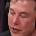

In [40]:
from IPython.display import Image
Image(filename=r"C:\Users\Anurag\1First\Projects\EM files\Seperate_faces\To feed tensorflow\Train\Melon\179.jpeg")

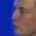

In [41]:
Image(filename=r"C:\Users\Anurag\1First\Projects\EM files\Seperate_faces\To feed tensorflow\Train\Melon\243.jpeg")

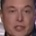

In [44]:
Image(filename=r"C:\Users\Anurag\1First\Projects\EM files\Seperate_faces\To feed tensorflow\Train\Melon\117.jpeg")

Examples of images without Elon

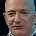

In [46]:
Image(filename=r"C:\Users\Anurag\1First\Projects\EM files\Seperate_faces\To feed tensorflow\Train\Nelon\6.jpeg")

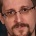

In [47]:
Image(filename=r"C:\Users\Anurag\1First\Projects\EM files\Seperate_faces\To feed tensorflow\Train\Nelon\45.jpeg")

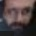

In [48]:
Image(filename=r"C:\Users\Anurag\1First\Projects\EM files\Seperate_faces\To feed tensorflow\Train\Nelon\20.jpeg")

In [ ]:
# Importing the Keras libraries and packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import time
import numpy 

# Normalizing the images and image augmentation by randomly zooming and randomly flipping  
# some of the training images.This creates variation in the training data which might help
# it generalise better. There are 174 of other's faces and 99 of Elon's faces.
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   zoom_range = 0.2,horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale = 1./255)

test_path = r"C:\Users\Anurag\1First\Projects\EM files\Seperate_faces\To feed tensorflow\Test"
train_path = r"C:\Users\Anurag\1First\Projects\EM files\Seperate_faces\To feed tensorflow\Train"

# Assuming that training a model will be easy, we can try to brute force search the 
# hyperparameter space for the ones that have the highest accuracy or lowest loss.
# The various combinations are listed below. These values will be used in tuning
# multiple hyperparameters throught all the layers.This will result in a total of
# 1152 models.
batch_size_list = [16,32,64]
kernel_size_list = [2,3,4,6]
extra_layers = [True,False]

for batch_size_var in batch_size_list:
    for filter_var in batch_size_list:
        for kernel_var in kernel_size_list:
            for pool_var in kernel_size_list:
                for first_extra_layer in extra_layers:
                    for second_extra_layer in extra_layers:
                        for third_extra_layer in extra_layers:
                            # Values 16,32,64 are tried to get the number of training examples 
                            # that go through the network in one pass before updating the
                            # weights. This is the 'batch_size' argument here
                            training_set = train_datagen.flow_from_directory(train_path,target_size = (64, 64),batch_size = batch_size_var, class_mode = 'binary')
                            test_set = test_datagen.flow_from_directory(test_path,target_size = (64, 64),batch_size = batch_size_var, class_mode = 'binary')
                            
# Creating a sequential CNN with two pairs of alternating convolution layers and maxpooling 
# layers. The number of filters and kernel sizes are varied of the convolutional layer.
# The pool size is varied in the maxpooling layer. Also three other layers are added in all 
# combinations. 
# ReLU activation functions are in all layers but the last. The last layer makes use of the 
# sigmoid activation function to output a 0 or 1, since this is a case of binary classification.
# Since the images are already zoomed in on the face, the images are ensured to not lose size
# by keeping padding='same' throughout the layers.
# A binary crossentropy loss function is minimized by the Adam optimizer.
# The accuracy and loss for both the training and test set is logged and can be viewed in 
# TensorBoard.
                            classifier_cnn = Sequential()
                            classifier_cnn.add(Conv2D(filter_var, (kernel_var, kernel_var), input_shape = (64, 64, 3), activation = 'relu', padding="same"))
                            classifier_cnn.add(MaxPooling2D(pool_size = (pool_var,pool_var), padding="same"))
                            classifier_cnn.add(Conv2D(filter_var, (kernel_var, kernel_var), activation = 'relu', padding="same"))
                            classifier_cnn.add(MaxPooling2D(pool_size = (pool_var,pool_var), padding="same"))
                            if first_extra_layer:
                                classifier_cnn.add(Conv2D(filter_var, (kernel_var, kernel_var), activation = 'relu', padding="same"))
                                classifier_cnn.add(MaxPooling2D(pool_size = (pool_var,pool_var), padding="same"))
                            if second_extra_layer:
                                classifier_cnn.add(Conv2D(filter_var, (kernel_var, kernel_var), activation = 'relu', padding="same"))
                                classifier_cnn.add(MaxPooling2D(pool_size = (pool_var,pool_var), padding="same"))
                            classifier_cnn.add(Flatten())
                            if third_extra_layer:
                                classifier_cnn.add(Dense(units = 128, activation = 'relu'))
                            classifier_cnn.add(Dense(units = 1, activation = 'sigmoid'))

                            classifier_cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
# Callback functions are created to be called during the fit method in order to log the accuracy
# and loss at each epoch for each model.
                            NAME = "bsv_" + str(batch_size_var) + "-fv_" + str(filter_var) + "-kv_" + str(kernel_var) + "-pv_" + str(pool_var) + "-fel_" + str(first_extra_layer) + "-sel_" + str(second_extra_layer) + "-tel_" + str(third_extra_layer)
                            tensorboard = TensorBoard(log_dir = 'logs\{}'.format(NAME))
                            
                            call_back = classifier_cnn.fit(training_set, epochs = 50, validation_data = test_set, callbacks=[tensorboard])
                            history_address = r"C:\Users\Anurag\1First\Projects\EM files\Nbs\history_logs\\" + NAME
                            numpy.save(history_address, call_back.history)

In [1]:
#Read log history and save only the required values seperately

import os
import numpy
loss_train = []
acc_train = []
loss_val = []
acc_val = []


for root, dirs, files in os.walk(r"C:\Users\Anurag\1First\Projects\EM files\Nbs\history_logs"):
    for name in files:
        file_address = os.path.join(root,name)
        history = numpy.load(file_address,allow_pickle='TRUE').item()
#Only the four required metrics are accessed
        history['loss'].insert(0,name)
        history['accuracy'].insert(0,name)
        history['val_loss'].insert(0,name)
        history['val_accuracy'].insert(0,name)
        
        loss_train.append(history['loss'])
        acc_train.append(history['accuracy'])
        loss_val.append(history['val_loss'])
        acc_val.append(history['val_accuracy'])
#Metrics are saved seperately
# numpy.savetxt(r"C:\Users\Anurag\Desktop\tableau metricss\loss_train.csv",numpy.transpose(loss_train),fmt="%s",delimiter=",")
# numpy.savetxt(r"C:\Users\Anurag\Desktop\tableau metricss\loss_val.csv",numpy.transpose(loss_val),fmt="%s",delimiter=",")
# numpy.savetxt(r"C:\Users\Anurag\Desktop\tableau metricss\acc_train.csv",numpy.transpose(acc_train),fmt="%s",delimiter=",")
# numpy.savetxt(r"C:\Users\Anurag\Desktop\tableau metricss\acc_val.csv",numpy.transpose(acc_val),fmt="%s",delimiter=",")

In [2]:
# Find top ten models with highest validation accuracy and top ten models with lowest validation
# loss seperately. The models are ranked on the basis of the average of their values in the last
# 'average_of' epochs. Here the average of the last 5 are used to rank the models.

average_of = 5

loss_val_rank = []
for i in loss_val:
    avg = sum(i[-average_of:])/average_of
    loss_val_rank.append([i[0],avg])
loss_val_rank_np = numpy.array(loss_val_rank)
loss_val_rank_np = loss_val_rank_np[loss_val_rank_np[:,1].argsort()]

acc_val_rank = []
for j in acc_val:
    avg = sum(j[-average_of:])/average_of
    acc_val_rank.append([j[0],avg])
acc_val_rank_np = numpy.array(acc_val_rank)
acc_val_rank_np = acc_val_rank_np[acc_val_rank_np[:,1].argsort()[::-1]]

Both ranked lists have the same model at the top.

In [3]:
loss_val_rank_np

array([['bsv_32-fv_32-kv_4-pv_2-fel_True-sel_True-tel_True.npy',
        '0.19210668593645094'],
       ['bsv_16-fv_64-kv_3-pv_3-fel_True-sel_True-tel_True.npy',
        '0.20732003815472128'],
       ['bsv_32-fv_64-kv_4-pv_3-fel_True-sel_True-tel_True.npy',
        '0.2112583436816931'],
       ...,
       ['bsv_32-fv_16-kv_2-pv_4-fel_False-sel_True-tel_False.npy',
        '0.5823477101325989'],
       ['bsv_32-fv_16-kv_2-pv_4-fel_True-sel_False-tel_False.npy',
        '0.5924702906608582'],
       ['bsv_64-fv_16-kv_2-pv_4-fel_True-sel_True-tel_False.npy',
        '0.6141326824824016']], dtype='<U56')

In [4]:
acc_val_rank_np

array([['bsv_32-fv_32-kv_4-pv_2-fel_True-sel_True-tel_True.npy',
        '0.9380645155906677'],
       ['bsv_16-fv_64-kv_6-pv_3-fel_True-sel_False-tel_False.npy',
        '0.9264516234397888'],
       ['bsv_16-fv_64-kv_6-pv_3-fel_True-sel_False-tel_True.npy',
        '0.9264516115188599'],
       ...,
       ['bsv_32-fv_16-kv_2-pv_4-fel_True-sel_True-tel_False.npy',
        '0.6425806522369385'],
       ['bsv_32-fv_16-kv_2-pv_4-fel_False-sel_True-tel_False.npy',
        '0.629677414894104'],
       ['bsv_64-fv_16-kv_2-pv_4-fel_True-sel_False-tel_False.npy',
        '0.6090322732925415']], dtype='<U56')

The best performing model is used to train and to save

In [5]:
training_set = train_datagen.flow_from_directory(train_path,target_size = (64, 64),batch_size = 32, class_mode = 'binary')
test_set = test_datagen.flow_from_directory(test_path,target_size = (64, 64),batch_size = 32, class_mode = 'binary')

classifier_cnn = Sequential()
classifier_cnn.add(Conv2D(32, (4, 4), input_shape = (64, 64, 3), activation = 'relu', padding="same"))
classifier_cnn.add(MaxPooling2D(pool_size = (2,2), padding="same"))
classifier_cnn.add(Conv2D(32, (4, 4), activation = 'relu', padding="same"))
classifier_cnn.add(MaxPooling2D(pool_size = (2,2), padding="same"))
classifier_cnn.add(Conv2D(32, (4, 4), activation = 'relu', padding="same"))
classifier_cnn.add(MaxPooling2D(pool_size = (2,2), padding="same"))
classifier_cnn.add(Conv2D(32, (4, 4), activation = 'relu', padding="same"))
classifier_cnn.add(MaxPooling2D(pool_size = (2,2), padding="same"))
classifier_cnn.add(Flatten())
classifier_cnn.add(Dense(units = 128, activation = 'relu'))
classifier_cnn.add(Dense(units = 1, activation = 'sigmoid'))

classifier_cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

NAME = "final_classifier"
tensorboard = TensorBoard(log_dir = 'logs\{}'.format(NAME))

classifier_cnn.fit(training_set, epochs = 25, validation_data = test_set, callbacks=[tensorboard])

Found 273 images belonging to 2 classes.
Found 113 images belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 9 steps, validate for 4 steps
Epoch 1/25
9/9 [==============================] - 1s 114ms/step - loss: 0.6854 - accuracy: 0.5971 - val_loss: 0.6399 - val_accuracy: 0.6637
Epoch 2/25
9/9 [==============================] - 0s 42ms/step - loss: 0.6495 - accuracy: 0.6374 - val_loss: 0.6353 - val_accuracy: 0.6637
Epoch 3/25
9/9 [==============================] - 0s 42ms/step - loss: 0.6311 - accuracy: 0.6374 - val_loss: 0.5999 - val_accuracy: 0.6372
Epoch 4/25
9/9 [==============================] - 0s 41ms/step - loss: 0.6000 - accuracy: 0.6447 - val_loss: 0.5596 - val_accuracy: 0.6549
Epoch 5/25
9/9 [==============================] - 0s 41ms/step - loss: 0.5561 - accuracy: 0.6850 - val_loss: 0.5415 - val_accuracy: 0.6991
Epoch 6/25
9/9 [==============================] - 0s 41ms/step - loss: 0.5542 - accuracy: 0.6777 - val_loss: 0.5215 - val_accuracy: 

In [12]:
classifier_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 64, 64, 32)        1568      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 32)        16416     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 32)        16416     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 8, 8, 32)         

In [ ]:
classifier_cnn.save(r"C:\Users\Anurag\Desktop\super_model")

#### Possible improvements

(.) Flagging accuracy can be improved by changing flagging algorithm slightly
(.) Model can be trained with more images for better generaliasation
(.) Live videos can be included in being flagged
(.) Ensemble models can be made use of for training
(.) CNN parameter can be used to improve face dectection accuracy in the face_recognition package
(.) A time scheduler can be used to ensure that the program runs at the same hour of the day everyday
(.) The new videos can be notified to the user actively (by mail or message) rather than passively (currently being saved into a file)
(.) Chrome can be made to run windowless bug-free with some amount of effort in Selenium
(.) The face recognition feature of the face_recognition package can be made use of instead of training our own model